In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
from torch import optim
import mgplvm
from mgplvm import kernels, rdist
from mgplvm.manifolds import Torus
from mgplvm.models import Core
from mgplvm.training import train
plt.rcParams.update({'font.size': 22})
np.random.seed(14042010)
torch.manual_seed(14042010)

In [2]:
torch.set_default_dtype(torch.float64)
device = mgplvm.utils.get_device("cuda")  # get_device("cpu")

d = 1  # dims of latent space
n_z = 15  # number of inducing points
n_samples = 1  # number of samples

with open('fly_data.tsv', newline='') as csvfile:
    data = list(csv.reader(csvfile, delimiter='\t'))
Y = np.expand_dims(np.array(data), 2).astype(float)
n, m = Y.shape[:2]

# specify manifold, kernel and rdist
d = 1
manif = Torus(m, d)
ref_dist = mgplvm.rdist.MVN(m, d, sigma=1.5)
# initialize signal variance
alpha = np.mean(np.std(Y, axis=1), axis=1)
kernel = kernels.QuadExp(n, manif.distance, alpha=alpha)
# generate model
sigma = np.mean(np.std(Y, axis=1), axis=1)  # initialize noise
mod = Core(manif, n, m, n_z, kernel, ref_dist, sigma=sigma).to(device)

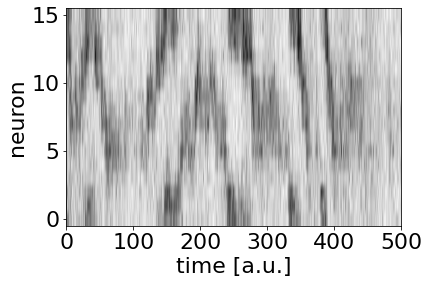

In [3]:
plt.figure()
Yplot = Y[:, :, 0]
plt.imshow(Yplot, cmap='Greys', aspect='auto', origin = 'upper')
plt.xlabel("time [a.u.]")
plt.ylabel("neuron")
plt.xlim(0,500)
plt.ylim(-0.5,n-0.5)
plt.show()
plt.close()

In [4]:
# train model
trained_mod = train(Y,
                    mod,
                    device,
                    optimizer=optim.Adam,
                    outdir='none',
                    max_steps=1000,
                    burnin='default',
                    n_b=64,
                    lrate=5E-2,
                    print_every=50)


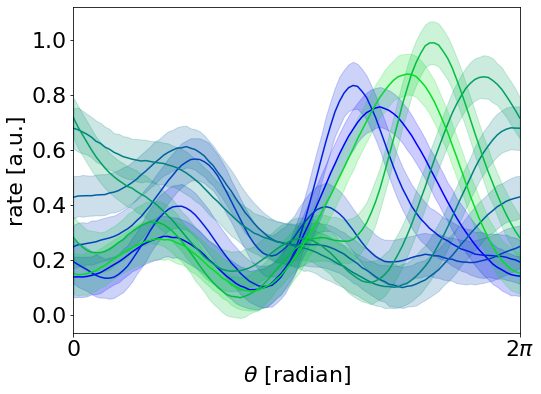

In [5]:
#%% plot tuning curves
query = torch.tensor(np.linspace(0, 2 * np.pi, 100),
                     dtype=torch.get_default_dtype(),
                     device=device)
data = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)
fmean, fstd = mod.predict(data, query, niter=1000)

plt.figure(figsize=(8, 6))
for i in range(0, 16, 2):
    xs, m, std = [arr.cpu().numpy() for arr in [query, fmean, fstd]]
    m, std = [arr[i, :, 0] for arr in [m, std]]
    col = [0, i/16, 1-i/16]
    plt.plot(xs, m, "-", color = col)
    plt.fill_between(xs, m - 2 * std, m + 2 * std, color=col, alpha=0.2)

plt.xlabel(r"$\theta$ [radian]")
plt.ylabel(r"rate [a.u.]")
plt.xlim(0, 2 * np.pi)
plt.xticks([0, 2*np.pi], [r'$0$', r'$2\pi$'])
plt.show()
plt.close()